<a href="https://colab.research.google.com/github/sedaoturak/Quantum_Espresso_Colab/blob/main/J14_binaries_statistical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
%%capture
!pip install mp-api
!pip install mpcontribs-client
!pip install pymatgen

In [2]:
# restart runtime after running this cell
%%capture
!pip install pydantic
!pip install boto3

In [1]:
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import json
import copy
import numpy as np
import pandas as pd
import math
import re
import pickle
from google.colab import drive
drive.mount('/content/drive')

# change this directory with yours
PATH = '/content/drive/MyDrive/Colab Notebooks/1.Projects/J14/'

# get API key using one of two ways
api_key = None
try:       # this is for running locally
    import os
    api_key = os.environ['MAPI_KEY']
except:    # this is for running on Colab
    with open(PATH+'mp_api_key.txt', 'r') as f:
        api_key = f.readlines()[0].strip()

mpr = MPRester(api_key=api_key)
# assert helps catch potential bugs
assert api_key is not None, 'API key not set correctly in environment!'
assert api_key != '', 'API key not found in mp_api_key.txt file!'

import os
os.environ["MPRESTER_MUTE_PROGRESS_BARS"] = "false"

Mounted at /content/drive


# Load data

In [2]:
data_df = pd.read_csv(PATH+'data_all.csv')
data_df

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT
0,0,0,mp-1018097,BaCaO2,Ba1 Ca1 O2,0.199486,-2.865981,Tetragonal,False,54.8,1115.0,1060.2,556.150000,501.350000,54.8
1,1,1,mp-1019541,BaCa3O4,Ba1 Ca3 O4,0.181439,-3.004622,Cubic,False,54.8,1115.0,1060.2,570.525000,515.725000,54.8
2,2,2,mp-1183285,BaCaO3,Ba1 Ca1 O3,0.344531,-2.280756,Cubic,False,54.8,1115.0,1060.2,455.880000,481.296000,54.8
3,3,3,mp-1078915,Ba3CaO4,Ba3 Ca1 O4,0.127881,-2.816992,Cubic,False,54.8,1115.0,1060.2,541.775000,486.975000,54.8
4,4,4,mp-756930,BaCaO2,Ba1 Ca1 O2,0.054122,-3.011345,Orthorhombic,False,54.8,1115.0,1060.2,556.150000,501.350000,54.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,2147,2147,mp-33631,TiZn2O4,Ti1 Zn2 O4,0.046793,-2.480438,Orthorhombic,False,54.8,1941.0,1886.2,506.508571,516.238367,54.8
2148,2148,2148,mp-1042495,Ti3Zn2O8,Ti3 Zn2 O8,0.044804,-2.935162,Hexagonal,False,54.8,1941.0,1886.2,588.212308,656.507456,54.8
2149,2149,2149,mp-1041539,Ti2ZnO4,Ti2 Zn1 O4,0.274993,-2.727138,Orthorhombic,False,54.8,1941.0,1886.2,684.840000,720.045714,54.8
2150,2150,2150,mp-1385424,TiZnO2,Ti1 Zn1 O2,0.420820,-2.206045,Monoclinic,False,54.8,1941.0,1886.2,685.820000,631.020000,54.8


# Data Acquisition

In [ ]:
# create all possible combinations of elements in question
element_list = ['Mg','Ca','Sr','Ba','Cr','Ti','Fe','Mn','Co','Ni','Cu','Zn']
n_combs = [2]
# element_list_sorted = sorted(element_list)
all_combinations = sum([list(map(list, combinations(element_list, n))) for n in n_combs], [])

all_combinations

In [ ]:
# create chemcyc list of all combinations of the elements
all_combinations_chemsys = copy.deepcopy(all_combinations)
for i,a in enumerate(all_combinations_chemsys):
  all_combinations_chemsys[i]=all_combinations_chemsys[i][0]+'-'+all_combinations_chemsys[i][1]+'-'+all_combinations_chemsys[i][2]

In [ ]:
# create empty list to save all queries
data_query = []
for system in all_combinations_chemsys:
  query = mpr.summary.search(chemsys=system,
                             fields=['composition','formula_pretty','material_id',
                                    'formation_energy_per_atom',
                                    'energy_above_hull'])
  data_query.append(query)

In [ ]:
# create empty dictionary to group data in columns
data = {'composition':[],'energy_above_hull':[],'formation_energy_per_atom':[],
        'formula_pretty':[],'material_id':[]}

for query in data_query:
  for i in range(len(query)):
    data['material_id'].append(query[i].material_id)
    data['composition'].append(query[i].composition)
    data['formula_pretty'].append(query[i].formula_pretty)
    data['formation_energy_per_atom'].append(query[i].formation_energy_per_atom)
    data['energy_above_hull'].append(query[i].energy_above_hull)

# convert distionary to dataframe
data_df = pd.DataFrame(data, columns=data.keys())
data_df.head()

In [ ]:
query = mpr.summary.search(
    # chemsys=['Co-Fe'],
                           material_ids=['mp-15225'],
                            # fields=['theoretical','symmetry','structure']
    )

Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
c = query[0].composition

In [ ]:
''.join(c.alphabetical_formula.split())

'Nd16O56Si16'

In [ ]:
experimental, crystal = [],[]
for id in data_df['material_id']:
  query = mpr.summary.search(material_ids=[id],
                              fields=['theoretical','symmetry'])
  experimental.append(query[0].theoretical)
  crystal.append(query[0].symmetry.crystal_system)

In [ ]:
data_df['experimentally_observed'] = experimental
data_df['crystal_system'] = crystal
data_df.to_csv(PATH+'data_all_additions.csv')

In [ ]:
data_df

,Unnamed: 0,composition,energy_above_hull,formation_energy_per_atom,formula_pretty,material_id,experimentally_observed,crystal_system
0,0,Ba1 Ca1 O2,0.199486,-2.865981,BaCaO2,mp-1018097,True,Tetragonal
1,1,Ba1 Ca3 O4,0.181439,-3.004622,BaCa3O4,mp-1019541,True,Cubic
2,2,Ba1 Ca1 O3,0.344531,-2.280756,BaCaO3,mp-1183285,True,Cubic
3,3,Ba3 Ca1 O4,0.127881,-2.816992,Ba3CaO4,mp-1078915,True,Cubic
4,4,Ba4 Ca4 O8,0.054122,-3.011345,BaCaO2,mp-756930,True,Orthorhombic
...,...,...,...,...,...,...,...,...
2147,2147,Ti2 Zn4 O8,0.046793,-2.480438,TiZn2O4,mp-33631,True,Orthorhombic
2148,2148,Ti6 Zn4 O16,0.044804,-2.935162,Ti3Zn2O8,mp-1042495,True,Hexagonal
2149,2149,Ti4 Zn2 O8,0.274993,-2.727138,Ti2ZnO4,mp-1041539,True,Orthorhombic
2150,2150,Ti4 Zn4 O8,0.420820,-2.206045,TiZnO2,mp-1385424,True,Monoclinic


In [ ]:
query[0]

MPDataDoc<SummaryDoc>(
fields_not_requested=['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_

## Matminer

In [ ]:
%%capture
!pip install matminer

In [ ]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
data_df = StrToComposition().featurize_dataframe(data_df, "formula_pretty")
ep_feat = ElementProperty.from_preset(preset_name="magpie")
data_df = ep_feat.featurize_dataframe(data_df, col_id="composition", ignore_errors=True)
data_df.head(3)

ElementProperty:   0%|          | 0/2152 [00:00<?, ?it/s]

,energy_above_hull,formation_energy_per_atom,formula_pretty,material_id,experimentally_observed,crystal_system,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.199486,-2.865981,BaCaO2,mp-1018097,True,Tetragonal,"(Ba, Ca, O)",8.0,56.0,48.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,119.5,107.5,12.0
1,0.181439,-3.004622,BaCa3O4,mp-1019541,True,Cubic,"(Ba, Ca, O)",8.0,56.0,48.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,119.0,107.0,12.0
2,0.344531,-2.280756,BaCaO3,mp-1183285,True,Cubic,"(Ba, Ca, O)",8.0,56.0,48.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,98.0,103.2,12.0


In [ ]:
include = ['material_id','formula_pretty','composition','energy_above_hull',
           'formation_energy_per_atom','crystal_system','experimentally_observed']
data_all = data_df[include]
data_all['min_meltingT'] = data_df['MagpieData minimum MeltingT']
data_all['max_meltingT'] = data_df['MagpieData maximum MeltingT']
data_all['range_meltingT'] = data_df['MagpieData range MeltingT']
data_all['mean_meltingT'] = data_df['MagpieData mean MeltingT']
data_all['avg_dev_meltingT'] = data_df['MagpieData avg_dev MeltingT']
data_all['mode_meltingT'] = data_df['MagpieData mode MeltingT']
data_all


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT
0,mp-1018097,BaCaO2,"(Ba, Ca, O)",0.199486,-2.865981,Tetragonal,True,54.8,1115.0,1060.2,556.150000,501.350000,54.8
1,mp-1019541,BaCa3O4,"(Ba, Ca, O)",0.181439,-3.004622,Cubic,True,54.8,1115.0,1060.2,570.525000,515.725000,54.8
2,mp-1183285,BaCaO3,"(Ba, Ca, O)",0.344531,-2.280756,Cubic,True,54.8,1115.0,1060.2,455.880000,481.296000,54.8
3,mp-1078915,Ba3CaO4,"(Ba, Ca, O)",0.127881,-2.816992,Cubic,True,54.8,1115.0,1060.2,541.775000,486.975000,54.8
4,mp-756930,BaCaO2,"(Ba, Ca, O)",0.054122,-3.011345,Orthorhombic,True,54.8,1115.0,1060.2,556.150000,501.350000,54.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,mp-33631,TiZn2O4,"(Ti, Zn, O)",0.046793,-2.480438,Orthorhombic,True,54.8,1941.0,1886.2,506.508571,516.238367,54.8
2148,mp-1042495,Ti3Zn2O8,"(Ti, Zn, O)",0.044804,-2.935162,Hexagonal,True,54.8,1941.0,1886.2,588.212308,656.507456,54.8
2149,mp-1041539,Ti2ZnO4,"(Ti, Zn, O)",0.274993,-2.727138,Orthorhombic,True,54.8,1941.0,1886.2,684.840000,720.045714,54.8
2150,mp-1385424,TiZnO2,"(Ti, Zn, O)",0.420820,-2.206045,Monoclinic,True,54.8,1941.0,1886.2,685.820000,631.020000,54.8


# Analysis

In [4]:
# create all possible combinations of elements in question
element_list = ['Mg','Ca','Sr','Ba','Cr','Ti','Fe','Mn','Co','Ni','Cu','Zn']
n_combs = [2]
# element_list_sorted = sorted(element_list)
all_combinations = sum([list(map(list, combinations(element_list, n))) for n in n_combs], [])
all_combinations

[['Mg', 'Ca'],
 ['Mg', 'Sr'],
 ['Mg', 'Ba'],
 ['Mg', 'Cr'],
 ['Mg', 'Ti'],
 ['Mg', 'Fe'],
 ['Mg', 'Mn'],
 ['Mg', 'Co'],
 ['Mg', 'Ni'],
 ['Mg', 'Cu'],
 ['Mg', 'Zn'],
 ['Ca', 'Sr'],
 ['Ca', 'Ba'],
 ['Ca', 'Cr'],
 ['Ca', 'Ti'],
 ['Ca', 'Fe'],
 ['Ca', 'Mn'],
 ['Ca', 'Co'],
 ['Ca', 'Ni'],
 ['Ca', 'Cu'],
 ['Ca', 'Zn'],
 ['Sr', 'Ba'],
 ['Sr', 'Cr'],
 ['Sr', 'Ti'],
 ['Sr', 'Fe'],
 ['Sr', 'Mn'],
 ['Sr', 'Co'],
 ['Sr', 'Ni'],
 ['Sr', 'Cu'],
 ['Sr', 'Zn'],
 ['Ba', 'Cr'],
 ['Ba', 'Ti'],
 ['Ba', 'Fe'],
 ['Ba', 'Mn'],
 ['Ba', 'Co'],
 ['Ba', 'Ni'],
 ['Ba', 'Cu'],
 ['Ba', 'Zn'],
 ['Cr', 'Ti'],
 ['Cr', 'Fe'],
 ['Cr', 'Mn'],
 ['Cr', 'Co'],
 ['Cr', 'Ni'],
 ['Cr', 'Cu'],
 ['Cr', 'Zn'],
 ['Ti', 'Fe'],
 ['Ti', 'Mn'],
 ['Ti', 'Co'],
 ['Ti', 'Ni'],
 ['Ti', 'Cu'],
 ['Ti', 'Zn'],
 ['Fe', 'Mn'],
 ['Fe', 'Co'],
 ['Fe', 'Ni'],
 ['Fe', 'Cu'],
 ['Fe', 'Zn'],
 ['Mn', 'Co'],
 ['Mn', 'Ni'],
 ['Mn', 'Cu'],
 ['Mn', 'Zn'],
 ['Co', 'Ni'],
 ['Co', 'Cu'],
 ['Co', 'Zn'],
 ['Ni', 'Cu'],
 ['Ni', 'Zn'],
 ['Cu', 'Zn']]

In [5]:
# create a list to save elements in a list and add this as a new column to the dataframe
elements_list = []

for datum in data_df.composition:
  string = str(datum)
  element_names = re.findall('(\D+)', string.replace(" ", ""))
  element_names.remove('O')
  elements_list.append(element_names)
data_df['element_list'] = elements_list
data_df

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT,element_list
0,0,0,mp-1018097,BaCaO2,Ba1 Ca1 O2,0.199486,-2.865981,Tetragonal,False,54.8,1115.0,1060.2,556.150000,501.350000,54.8,"[Ba, Ca]"
1,1,1,mp-1019541,BaCa3O4,Ba1 Ca3 O4,0.181439,-3.004622,Cubic,False,54.8,1115.0,1060.2,570.525000,515.725000,54.8,"[Ba, Ca]"
2,2,2,mp-1183285,BaCaO3,Ba1 Ca1 O3,0.344531,-2.280756,Cubic,False,54.8,1115.0,1060.2,455.880000,481.296000,54.8,"[Ba, Ca]"
3,3,3,mp-1078915,Ba3CaO4,Ba3 Ca1 O4,0.127881,-2.816992,Cubic,False,54.8,1115.0,1060.2,541.775000,486.975000,54.8,"[Ba, Ca]"
4,4,4,mp-756930,BaCaO2,Ba1 Ca1 O2,0.054122,-3.011345,Orthorhombic,False,54.8,1115.0,1060.2,556.150000,501.350000,54.8,"[Ba, Ca]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,2147,2147,mp-33631,TiZn2O4,Ti1 Zn2 O4,0.046793,-2.480438,Orthorhombic,False,54.8,1941.0,1886.2,506.508571,516.238367,54.8,"[Ti, Zn]"
2148,2148,2148,mp-1042495,Ti3Zn2O8,Ti3 Zn2 O8,0.044804,-2.935162,Hexagonal,False,54.8,1941.0,1886.2,588.212308,656.507456,54.8,"[Ti, Zn]"
2149,2149,2149,mp-1041539,Ti2ZnO4,Ti2 Zn1 O4,0.274993,-2.727138,Orthorhombic,False,54.8,1941.0,1886.2,684.840000,720.045714,54.8,"[Ti, Zn]"
2150,2150,2150,mp-1385424,TiZnO2,Ti1 Zn1 O2,0.420820,-2.206045,Monoclinic,False,54.8,1941.0,1886.2,685.820000,631.020000,54.8,"[Ti, Zn]"


In [7]:
data_df_stable = data_df[data_df['energy_above_hull']==0.00]
data_df_stable

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT,element_list
5,5,5,mp-16887,Ba2CoO4,Ba2 Co1 O4,0.0,-2.333282,Monoclinic,True,54.8,1768.0,1713.2,569.600000,588.342857,54.8,"[Ba, Co]"
6,6,6,mp-18965,BaCoO3,Ba1 Co1 O3,0.0,-2.053641,Hexagonal,True,54.8,1768.0,1713.2,586.480000,638.016000,54.8,"[Ba, Co]"
24,24,24,mp-19086,BaCoO2,Ba1 Co1 O2,0.0,-2.081859,Trigonal,True,54.8,1768.0,1713.2,719.400000,664.600000,54.8,"[Ba, Co]"
31,31,31,mp-1281162,Ba3Cr2O8,Ba3 Cr2 O8,0.0,-2.630381,Triclinic,False,54.8,2180.0,2125.2,599.876923,670.863905,54.8,"[Ba, Cr]"
34,34,34,mp-17520,Ba2CrO4,Ba2 Cr1 O4,0.0,-2.732621,Orthorhombic,True,54.8,2180.0,2125.2,628.457143,655.608163,54.8,"[Ba, Cr]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,2092,2092,mp-5532,Sr2TiO4,Sr2 Ti1 O4,0.0,-3.444999,Tetragonal,True,54.8,1941.0,1886.2,608.600000,632.914286,54.8,"[Sr, Ti]"
2093,2093,2093,mp-540640,Sr2Ti6O13,Sr2 Ti6 O13,0.0,-3.485900,Monoclinic,True,54.8,1941.0,1886.2,688.495238,784.575057,54.8,"[Sr, Ti]"
2095,2095,2095,mp-3349,Sr3Ti2O7,Sr3 Ti2 O7,0.0,-3.494004,Tetragonal,True,54.8,1941.0,1886.2,617.966667,657.027778,54.8,"[Sr, Ti]"
2105,2105,2105,mp-5637,SrZnO2,Sr1 Zn1 O2,0.0,-2.436152,Orthorhombic,True,54.8,1050.0,995.2,463.070000,408.270000,54.8,"[Sr, Zn]"


In [ ]:
data_df_filtered1 = data_df_stable[(data_df_stable['mean_meltingT']>700) & (data_df_stable['experimentally_observed']==True)]
data_df_filtered1

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT,element_list
24,24,24,mp-19086,BaCoO2,Ba1 Co1 O2,0.0,-2.081859,Trigonal,True,54.8,1768.00,1713.20,719.400000,664.600000,54.80,"[Ba, Co]"
44,44,44,mp-541137,BaCr2O4,Ba1 Cr2 O4,0.0,-2.603763,Orthorhombic,True,54.8,2180.00,2125.20,797.028571,848.261224,54.80,"[Ba, Cr]"
58,58,58,mp-7374,Ba(CuO)2,Ba1 Cu2 O2,0.0,-1.617098,Tetragonal,True,54.8,1357.77,1302.97,765.028000,568.182400,54.80,"[Ba, Cu]"
213,213,213,mp-28917,Ba2Ti13O22,Ba2 Ti13 O22,0.0,-3.366918,Orthorhombic,True,54.8,1941.00,1886.20,768.610811,848.856099,54.80,"[Ba, Ti]"
312,312,312,mp-540582,CaCr2O4,Ca1 Cr2 O4,0.0,-2.701681,Orthorhombic,True,54.8,2180.00,2125.20,813.457143,867.036735,54.80,"[Ca, Cr]"
602,602,602,mp-20758,Cr2CoO4,Cr2 Co1 O4,0.0,-2.136723,Cubic,True,54.8,2180.00,2125.20,906.742857,973.648980,54.80,"[Cr, Co]"
889,889,889,mp-504573,Cr2CuO4,Cr2 Cu1 O4,0.0,-3.378469,Cubic,True,54.8,2180.00,2125.20,848.138571,906.672653,54.80,"[Cr, Cu]"
932,932,932,mp-1104680,Cr2FeO4,Cr2 Fe1 O4,0.0,-2.181114,Tetragonal,True,54.8,2180.00,2125.20,912.885714,980.669388,54.80,"[Cr, Fe]"
1010,1010,1010,mp-19202,MgCr2O4,Mg1 Cr2 O4,0.0,-2.633956,Cubic,True,54.8,2180.00,2125.20,786.028571,835.689796,54.80,"[Mg, Cr]"
1023,1023,1023,mp-28226,MnCr2O4,Mn1 Cr2 O4,0.0,-2.337778,Cubic,True,54.8,2180.00,2125.20,871.171429,932.995918,54.80,"[Mn, Cr]"


In [ ]:
data_df_filtered2 = data_df_stable[(data_df_stable['mean_meltingT']>700) & (data_df_stable['experimentally_observed']==False)]
data_df_filtered2

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT,element_list
626,626,626,mp-757299,Co21Cu3O32,Co21 Cu3 O32,0.0,-1.300732,Trigonal,False,54.8,1768.0,1713.2,767.051964,814.002245,54.8,"[Co, Cu]"
727,727,727,mp-767791,Mg5Co19O32,Mg5 Co19 O32,0.0,-1.669867,Trigonal,False,54.8,1768.0,1713.2,713.582143,752.893878,54.8,"[Mg, Co]"
744,744,744,mp-1221996,Mn2CoO4,Mn2 Co1 O4,0.0,-1.842426,Tetragonal,False,54.8,1768.0,1713.2,717.885714,757.812245,54.8,"[Mn, Co]"
776,776,776,mp-754168,Co(NiO2)2,Co1 Ni2 O4,0.0,-1.165306,Cubic,False,54.8,1768.0,1713.2,777.600000,826.057143,54.8,"[Co, Ni]"
777,777,777,mp-1178424,CoNiO3,Co1 Ni1 O3,0.0,-1.142435,Trigonal,False,54.8,1768.0,1713.2,732.080000,812.736000,54.8,"[Co, Ni]"
835,835,835,mp-753066,Ti2CoO5,Ti2 Co1 O5,0.0,-2.967451,Orthorhombic,False,54.8,1941.0,1886.2,740.500000,857.125000,54.8,"[Ti, Co]"
1054,1054,1054,mp-1271107,Cr2NiO4,Cr2 Ni1 O4,0.0,-2.041544,Monoclinic,False,54.8,2180.0,2125.2,901.028571,967.118367,54.8,"[Cr, Ni]"
1444,1444,1444,mp-35596,Fe2NiO4,Fe2 Ni1 O4,0.0,-1.591768,Orthorhombic,False,54.8,1811.0,1756.2,795.600000,846.628571,54.8,"[Fe, Ni]"
1511,1511,1511,mp-1277107,TiFeO3,Ti1 Fe1 O3,0.0,-2.730476,Triclinic,False,54.8,1941.0,1886.2,783.280000,874.176000,54.8,"[Ti, Fe]"
2035,2035,2035,mp-766093,Ti4(Ni5O8)3,Ti4 Ni15 O24,0.0,-1.852247,Trigonal,False,54.8,1941.0,1886.2,813.934884,847.406382,54.8,"[Ti, Ni]"


In [8]:
data_df_filtered3 = data_df_stable[data_df_stable['experimentally_observed']==True]
data_df_filtered3

,Unnamed: 0.1,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT,element_list
5,5,5,mp-16887,Ba2CoO4,Ba2 Co1 O4,0.0,-2.333282,Monoclinic,True,54.8,1768.0,1713.2,569.600000,588.342857,54.8,"[Ba, Co]"
6,6,6,mp-18965,BaCoO3,Ba1 Co1 O3,0.0,-2.053641,Hexagonal,True,54.8,1768.0,1713.2,586.480000,638.016000,54.8,"[Ba, Co]"
24,24,24,mp-19086,BaCoO2,Ba1 Co1 O2,0.0,-2.081859,Trigonal,True,54.8,1768.0,1713.2,719.400000,664.600000,54.8,"[Ba, Co]"
34,34,34,mp-17520,Ba2CrO4,Ba2 Cr1 O4,0.0,-2.732621,Orthorhombic,True,54.8,2180.0,2125.2,628.457143,655.608163,54.8,"[Ba, Cr]"
44,44,44,mp-541137,BaCr2O4,Ba1 Cr2 O4,0.0,-2.603763,Orthorhombic,True,54.8,2180.0,2125.2,797.028571,848.261224,54.8,"[Ba, Cr]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,2085,2085,mp-28740,SrTi11O20,Sr1 Ti11 O20,0.0,-3.429344,Triclinic,True,54.8,1941.0,1886.2,734.281250,849.351562,54.8,"[Sr, Ti]"
2092,2092,2092,mp-5532,Sr2TiO4,Sr2 Ti1 O4,0.0,-3.444999,Tetragonal,True,54.8,1941.0,1886.2,608.600000,632.914286,54.8,"[Sr, Ti]"
2093,2093,2093,mp-540640,Sr2Ti6O13,Sr2 Ti6 O13,0.0,-3.485900,Monoclinic,True,54.8,1941.0,1886.2,688.495238,784.575057,54.8,"[Sr, Ti]"
2095,2095,2095,mp-3349,Sr3Ti2O7,Sr3 Ti2 O7,0.0,-3.494004,Tetragonal,True,54.8,1941.0,1886.2,617.966667,657.027778,54.8,"[Sr, Ti]"


In [ ]:
data_df_filtered4 = data_df_stable[data_df_stable['experimentally_observed']==False]
data_df_filtered4

,Unnamed: 0,material_id,formula_pretty,composition,energy_above_hull,formation_energy_per_atom,crystal_system,experimentally_observed,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT
5,5,mp-16887,Ba2CoO4,Ba2 Co1 O4,0.0,-2.333282,Monoclinic,False,54.8,1768.0,1713.2,569.600000,588.342857,54.8
6,6,mp-18965,BaCoO3,Ba1 Co1 O3,0.0,-2.053641,Hexagonal,False,54.8,1768.0,1713.2,586.480000,638.016000,54.8
24,24,mp-19086,BaCoO2,Ba1 Co1 O2,0.0,-2.081859,Trigonal,False,54.8,1768.0,1713.2,719.400000,664.600000,54.8
34,34,mp-17520,Ba2CrO4,Ba2 Cr1 O4,0.0,-2.732621,Orthorhombic,False,54.8,2180.0,2125.2,628.457143,655.608163,54.8
44,44,mp-541137,BaCr2O4,Ba1 Cr2 O4,0.0,-2.603763,Orthorhombic,False,54.8,2180.0,2125.2,797.028571,848.261224,54.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,2085,mp-28740,SrTi11O20,Sr1 Ti11 O20,0.0,-3.429344,Triclinic,False,54.8,1941.0,1886.2,734.281250,849.351562,54.8
2092,2092,mp-5532,Sr2TiO4,Sr2 Ti1 O4,0.0,-3.444999,Tetragonal,False,54.8,1941.0,1886.2,608.600000,632.914286,54.8
2093,2093,mp-540640,Sr2Ti6O13,Sr2 Ti6 O13,0.0,-3.485900,Monoclinic,False,54.8,1941.0,1886.2,688.495238,784.575057,54.8
2095,2095,mp-3349,Sr3Ti2O7,Sr3 Ti2 O7,0.0,-3.494004,Tetragonal,False,54.8,1941.0,1886.2,617.966667,657.027778,54.8


In [ ]:
data_df_filtered2[data_df_filtered2['crystal_system']=='Trigonal'].formula_pretty.values

array(['BaCoO2', 'FeCuO2', 'TiMnO3', 'TiNiO3'], dtype=object)

# Mesh Plot

In [ ]:
# for pcolormesh plot, save "the number of compounds" information into a dict
# create an empty dict by element names are the keys
data_pcolormesh = dict.fromkeys(element_list)
for k in data_pcolormesh.keys():
  data_pcolormesh[k]=list()

data_to_plot = data_df_filtered4

for i, ele in enumerate(element_list):
  # create an empty list just to save all numbers between the steps
  pcolormesh_list = []
  # create a dataframe with filtering the element type in the composition column
  df_ = data_to_plot[data_to_plot['composition'].str.contains(ele)]
  # search the number of compounds with each element
  for el in element_list:
    pcolormesh_list.append(df_[df_['composition'].str.contains(el)].count()[0])
  pcolormesh_list[i] = 0 # assign zero to same element combination, i.e. Fe-Fe (there is no compound like FeFeO)
  # save the numbers into dictionary as a 2D array
  data_pcolormesh[ele] = np.array(pcolormesh_list).reshape(-1,1)

# concatenate each list/value in the dict and convert them to np array
data_pcolormesh_np = np.concatenate([data_pcolormesh[x] for x in data_pcolormesh], 1)
data_pcolormesh_np.shape

(12, 12)

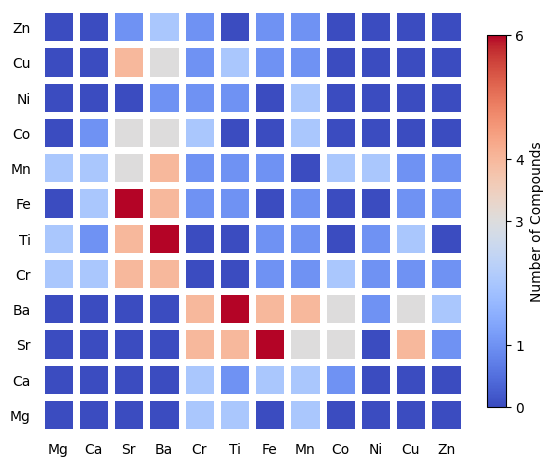

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap('coolwarm').copy()

pc = ax.pcolormesh(data_pcolormesh_np,cmap=cmap,vmin=data_pcolormesh_np.min(),
                   vmax=data_pcolormesh_np.max(),edgecolors='white',linewidth=5)

n_ticks = len(element_list)
tick_positions = np.linspace(0.5,n_ticks-0.5,n_ticks)
ax.set_yticks(tick_positions)
ax.set_yticklabels(element_list)
ax.set_xticks(tick_positions)
ax.set_xticklabels(element_list)
ax.tick_params(left=False, bottom=False,)
ax.set_aspect('equal')
ax.set_frame_on(False)
# ax.set_title('E$_{hull}$=0.00 eV/atom')

cbar = plt.colorbar(pc,fraction=0.04, ticks=np.linspace(0,data_pcolormesh_np.max(),5,dtype=int))
cbar.set_label('Number of Compounds')
plt.show()

In [ ]:
data_df_filtered3.describe()

,Unnamed: 0,energy_above_hull,formation_energy_per_atom,min_meltingT,max_meltingT,range_meltingT,mean_meltingT,avg_dev_meltingT,mode_meltingT
count,57.000000,57.0,57.000000,5.700000e+01,57.000000,57.000000,57.000000,57.000000,5.700000e+01
mean,1000.298246,0.0,-2.230205,5.480000e+01,1729.630351,1674.830351,637.395021,681.088864,5.480000e+01
std,683.802681,0.0,0.700074,7.168588e-15,236.652162,236.652162,84.107784,106.476977,7.168588e-15
min,31.000000,0.0,-3.556694,5.480000e+01,1357.770000,1302.970000,490.827692,529.603265,5.480000e+01
25%,343.000000,0.0,-2.606151,5.480000e+01,1519.000000,1464.200000,576.249057,591.350183,5.480000e+01
50%,844.000000,0.0,-2.108558,5.480000e+01,1768.000000,1713.200000,623.515789,658.513019,5.480000e+01
75%,1665.000000,0.0,-1.693059,5.480000e+01,1941.000000,1886.200000,680.600000,752.893878,5.480000e+01
max,2121.000000,0.0,-1.119569,5.480000e+01,2180.000000,2125.200000,901.028571,967.118367,5.480000e+01


# Network

Network graph is to represent mesh plot in a different way.
The elements are designated as circles or "nodes" with "edges" between them.

The nodes are placed according to "edge length", or the criterion of "the reciprocal of the number compounds" in this case. That is, if there are high number of compounds between two elements, the nodes representing those elements will be closer to each other compared the others having less number of compounds, in the plot.

In [3]:
%%capture
!pip install netgraph

In [9]:
# for pcolormesh plot, save "the number of compounds" information into a dict
# create an empty dict by element names are the keys
data_network = dict.fromkeys(element_list)
for k in data_network.keys():
  data_network[k]=list()

data_to_plot = data_df_filtered3

for i, ele in enumerate(element_list):
  # create an empty list just to save all numbers between the steps
  pcolormesh_list = []
  # create a dataframe with filtering the element type in the composition column
  df_ = data_to_plot[data_to_plot['composition'].str.contains(ele)]
  # search the number of compounds with each element
  for el in element_list:
    pcolormesh_list.append(df_[df_['composition'].str.contains(el)].count()[0])
  pcolormesh_list[i] = 0 # assign zero to same element combination, i.e. Fe-Fe (there is no compound like FeFeO)
  # save the numbers into dictionary as a 2D array
  data_network[ele] = np.array(pcolormesh_list).reshape(-1,1)

# concatenate each list/value in the dict and convert them to np array
data_network_np = np.concatenate([data_network[x] for x in data_network], 1)
data_network_np.shape

(12, 12)

In [10]:
# if there are 0 values (meaning no compound between a pair of elements)
# copy mesh plot data not to change the original data

data_network_np_nozero = np.float64(copy.deepcopy(data_network_np))
data_network_np_nozero[data_network_np_nozero<1] = 1e-1 # trick for 1/n
data_network_np_nozero

array([[0.1, 0.1, 0.1, 0.1, 2. , 2. , 0.1, 2. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 2. , 1. , 2. , 2. , 1. , 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 4. , 4. , 6. , 3. , 3. , 0.1, 4. , 1. ],
       [0.1, 0.1, 0.1, 0.1, 4. , 6. , 4. , 4. , 3. , 1. , 3. , 2. ],
       [2. , 2. , 4. , 4. , 0.1, 0.1, 1. , 1. , 2. , 1. , 1. , 1. ],
       [2. , 1. , 4. , 6. , 0.1, 0.1, 1. , 1. , 0.1, 1. , 2. , 0.1],
       [0.1, 2. , 6. , 4. , 1. , 1. , 0.1, 1. , 0.1, 0.1, 1. , 1. ],
       [2. , 2. , 3. , 4. , 1. , 1. , 1. , 0.1, 2. , 2. , 1. , 1. ],
       [0.1, 1. , 3. , 3. , 2. , 0.1, 0.1, 2. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 1. , 1. , 1. , 0.1, 2. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 4. , 3. , 1. , 2. , 1. , 1. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 1. , 2. , 1. , 0.1, 1. , 1. , 0.1, 0.1, 0.1, 0.1]])

In [11]:
# make list of indices of each element combination
comb_indices = [(element_list.index(c[0]),element_list.index(c[1])) for c in all_combinations]

# use this list to get number of compounds info from the np array
edge_widths = [np.power(np.reciprocal(data_network_np_nozero),1)[c] for c in comb_indices]

# create an empty dictionary to save element combinations as key and the edge width as value
edge_length = {}
for i,c in enumerate(all_combinations):
  edge_length[tuple(c)] = edge_widths[i]

# create a list of colors for each element node
node_colors = ['#78add2','#ceddf1','#ffb26e','#ffd6ae','#80c680',
               '#c1ebb8','#e67d7e','#ffc1c0','#bea4d7','#dccfe5',
               '#ba9993','#dbc3be']
# save the node colors in a dictionary
node_color={}
for i,a in enumerate(element_list):
  node_color[a]=node_colors[i]

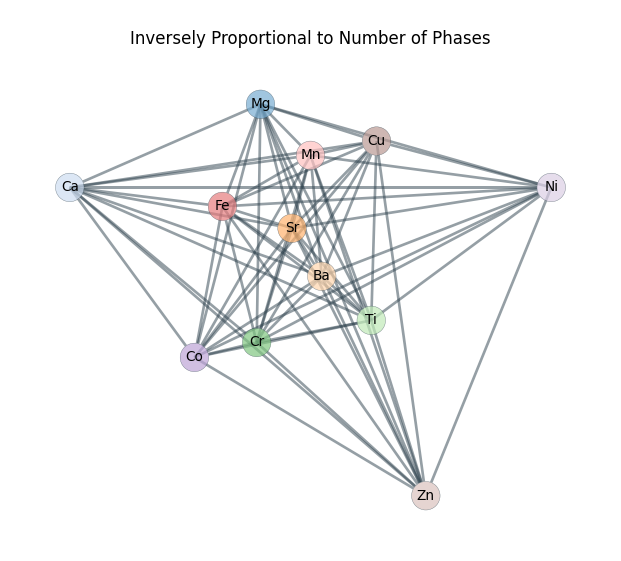

In [ ]:
from netgraph import Graph # pip install netgraph OR conda install -c conda-forge netgraph

fig, ax = plt.subplots(figsize=(3,2),dpi=300)
nt = Graph(all_combinations, node_labels=True, node_color=node_color, node_alpha=0.7,
           node_edge_width=7, node_layout='geometric',scale=(100,100),node_size=270,
           node_layout_kwargs=dict(edge_length=edge_length, tol=1e-3), edge_width=50, ax=ax)
ax.set_aspect('equal')
ax.set_title('Inversely Proportional to Number of Phases',fontsize=4)
plt.show()
# save graph as figure
# plt.savefig(PATH+'nt1_filter1.png', dpi=300)
# save graph object to file
pickle.dump(nt, open(PATH+'nt1_filter4.pickle', 'wb'))

invalid value encountered in divide


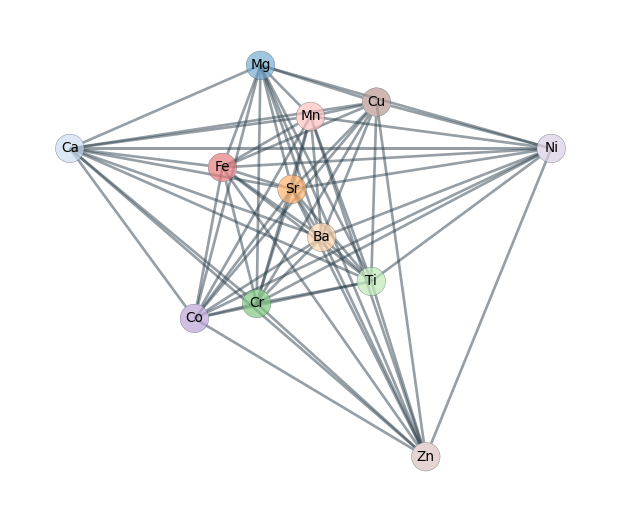

In [13]:
from netgraph import Graph
# open a saved graph and replot
nt = pickle.load(open(PATH+'nt1_filter4.pickle', 'rb'))

fig, ax = plt.subplots(figsize=(3,2),dpi=300)
nt = Graph(nt.edges,node_layout=nt.node_positions,node_labels=True,
           node_color=node_color, node_alpha=0.7, node_edge_width=7,
           scale=(100,100),node_size=270, edge_width=50,ax=ax)

## Distance metric

In [16]:
data_distances = {}
keys,distances = [],[]
for k in nt.edge_paths.keys():
  a,b = [*nt.edge_paths[k].T]
  distance = np.linalg.norm(a - b)
  data_distances[k] = distance

In [ ]:
elements = element_list
n_combs = [5]
all_combinations = sum([list(map(list, combinations(elements, n))) for n in n_combs], [])
all_combinations

In [17]:
quinary_distance = {}
for a in tqdm(all_combinations):
  combs = sum([list(map(tuple, combinations(a, n))) for n in [2]], [])
  distance_sum = []
  for c in combs:
    for k in data_distances.keys():
      if c==k or c[::-1]==k:
        distance_sum.append(data_distances[k])

  quinary_distance[tuple(a)]=sum(distance_sum)

100%|██████████| 792/792 [00:00<00:00, 1149.70it/s]


In [21]:
quinary_distance_df = pd.DataFrame(data=list(quinary_distance.items()),
                                      columns=['Compound','Distance'])
quinary_distance_df = quinary_distance_df.sort_values(by='Distance',ascending=True)
quinary_distance_df[:20]

,Compound,Distance
542,"(Sr, Ba, Cr, Ti, Co)",151.726766
676,"(Ba, Cr, Ti, Co, Cu)",153.527153
556,"(Sr, Ba, Cr, Co, Cu)",159.500120
544,"(Sr, Ba, Cr, Ti, Cu)",172.818439
675,"(Ba, Cr, Ti, Co, Ni)",177.705461
555,"(Sr, Ba, Cr, Co, Ni)",183.469357
697,"(Ba, Cr, Co, Ni, Cu)",185.185468
671,"(Ba, Cr, Ti, Mn, Co)",189.318679
606,"(Sr, Cr, Ti, Co, Cu)",190.323786
571,"(Sr, Ba, Ti, Co, Cu)",190.448060


In [23]:
quinary_distance_df[772:]

,Compound,Distance
35,"(Mg, Ca, Sr, Cu, Zn)",622.468664
117,"(Mg, Ca, Co, Ni, Zn)",627.161380
78,"(Mg, Ca, Cr, Mn, Zn)",628.673742
57,"(Mg, Ca, Ba, Mn, Zn)",628.715521
98,"(Mg, Ca, Ti, Ni, Zn)",632.035701
112,"(Mg, Ca, Mn, Co, Zn)",633.830876
34,"(Mg, Ca, Sr, Ni, Zn)",634.412236
119,"(Mg, Ca, Ni, Cu, Zn)",635.149834
93,"(Mg, Ca, Ti, Mn, Zn)",638.523174
29,"(Mg, Ca, Sr, Mn, Zn)",640.820680


# Pie Chart

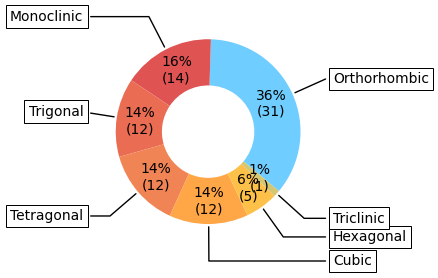

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

data_to_pie = data_df_filtered4
crystal_stats = data_to_pie['crystal_system'].value_counts()
labels = list(crystal_stats.keys())
pie_nelements = crystal_stats.values
pie_colors = ['#70CDFF','#DF5353','#EA6D53','#F18455','#FFA647','#FDC149','#D5C672']
total = len(data_to_pie['crystal_system'])
def pct_func(x):
  return '{:.0f}%\n({:.0f})'.format(x, total*x/100)

wedges, texts, pcts = ax.pie(pie_nelements, wedgeprops=dict(width=0.5), startangle=-40,
                      colors=pie_colors,autopct=pct_func,pctdistance=0.75)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.show()

# Save data

In [ ]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

with open(PATH+'input_cheat.json', 'w') as f:
  json.dump(input_cheat, f, cls=NpEncoder)

In [ ]:
data_df.to_csv(PATH+'data_all.csv')